## Домашнее задание №5

1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). 

In [272]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

from sklearn.model_selection import train_test_split

In [273]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [274]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [275]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [276]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [277]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [278]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [279]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [280]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf = None):
    
    if min_leaf is None:
        min_leaf = 1
    else:
        min_leaf = min_leaf
    


    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    # у нас всего 2 признака, поэтому обучать будем каждый раз на обоих
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [281]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, min_leaf):

    quality, t, index = find_best_split(data, labels, min_leaf)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, min_leaf)
    false_branch = build_tree(false_data, false_labels, min_leaf)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [282]:
# функция формирования случайного леса

def random_forest(data, labels, n_trees, min_leaf):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels, min_leaf))
        
    return forest

In [283]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [284]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [285]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [286]:
data_s, labels_s = datasets.make_classification(n_samples=500, n_features = 2, n_informative = 2, n_classes = 2, 
                                                n_redundant=0, n_clusters_per_class=1, random_state=23)

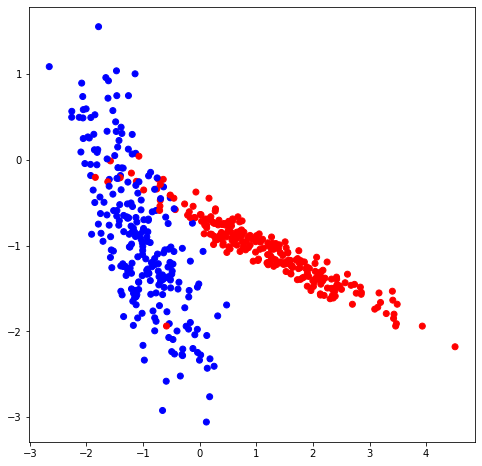

In [287]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], data_s)), list(map(lambda x: x[1], data_s)), c=labels_s, cmap=colors)
plt.show()

In [288]:
data_train, data_test, labels_train, labels_test = train_test_split(data_s, labels_s, test_size = 0.3)

In [289]:
data_train.shape

(350, 2)

In [290]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Точность случайного леса из 1 деревьев на обучающей выборке: 95.714
Точность случайного леса из 1 деревьев на тестовой выборке: 96.667


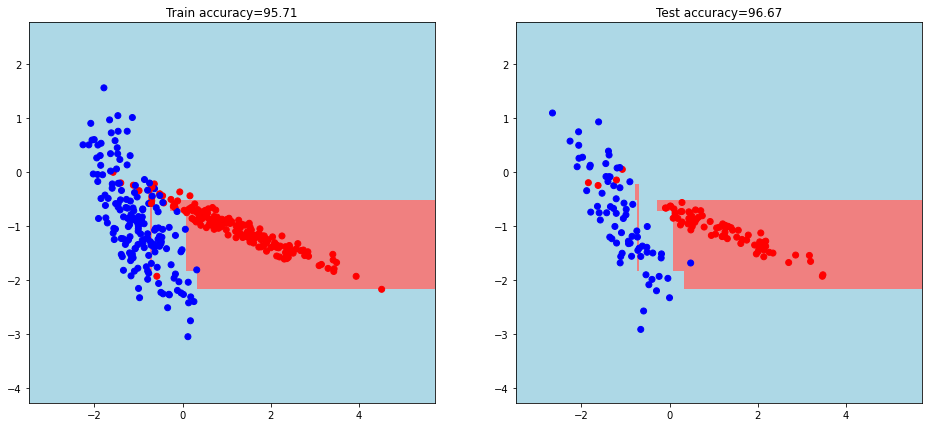

Точность случайного леса из 3 деревьев на обучающей выборке: 96.000
Точность случайного леса из 3 деревьев на тестовой выборке: 96.000


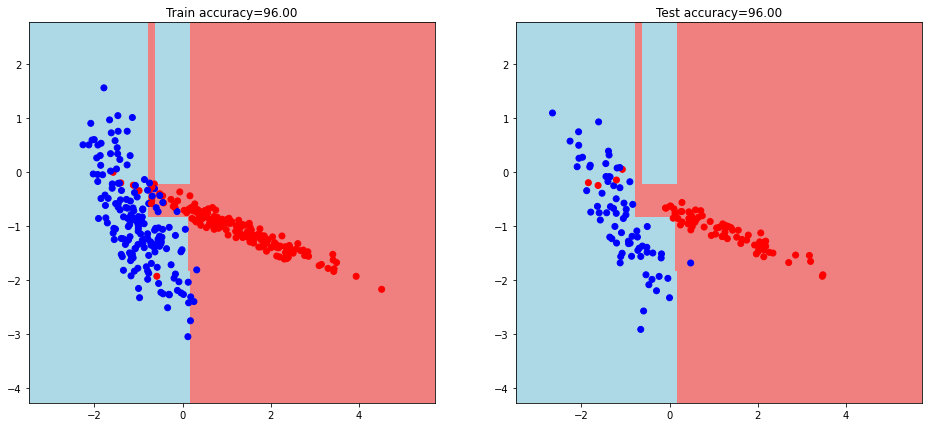

Точность случайного леса из 10 деревьев на обучающей выборке: 97.714
Точность случайного леса из 10 деревьев на тестовой выборке: 96.000


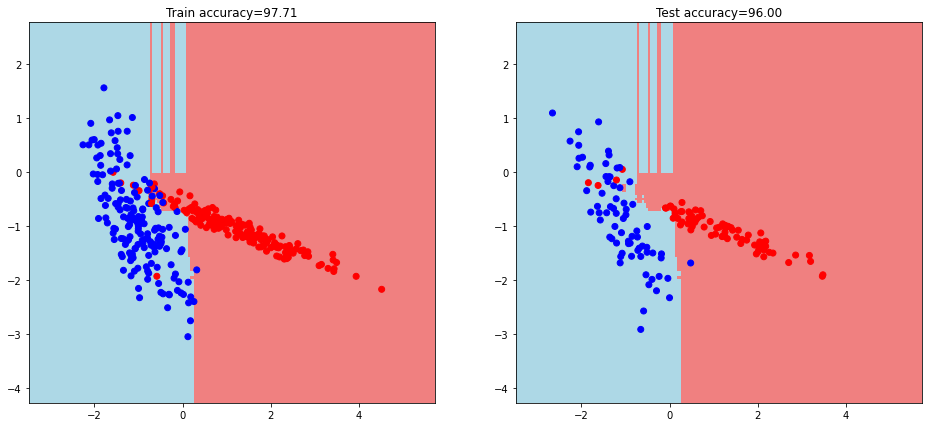

Точность случайного леса из 50 деревьев на обучающей выборке: 97.714
Точность случайного леса из 50 деревьев на тестовой выборке: 96.667


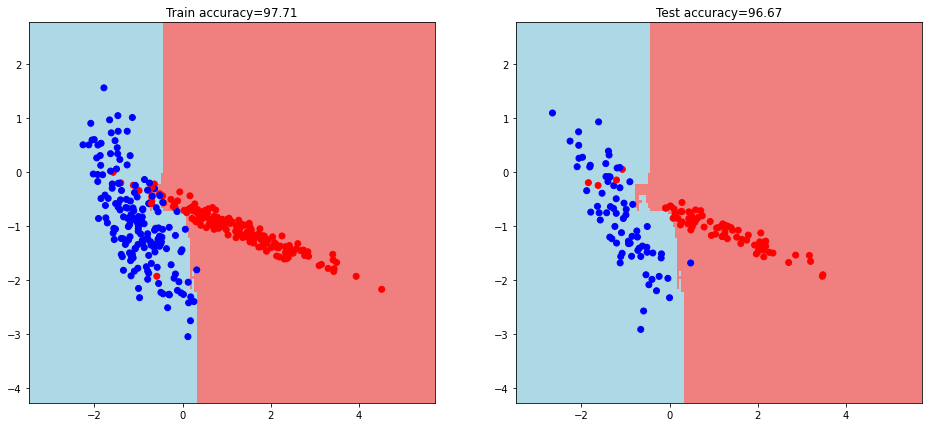

Точность случайного леса из 150 деревьев на обучающей выборке: 98.000
Точность случайного леса из 150 деревьев на тестовой выборке: 96.667


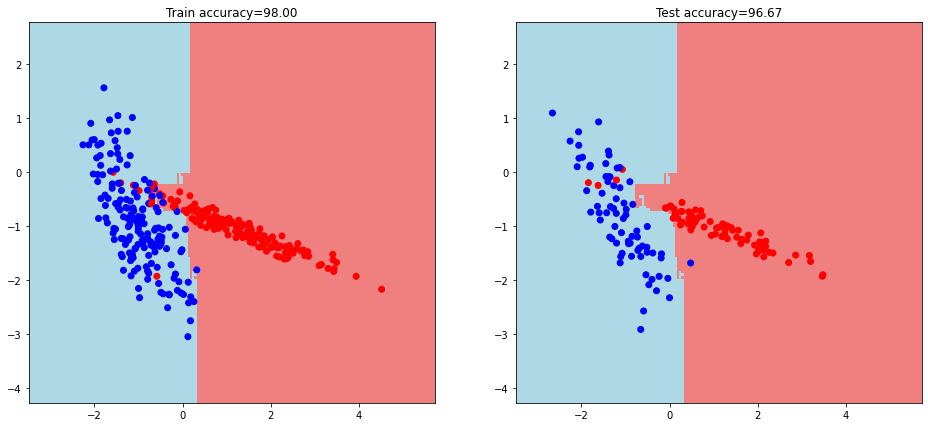

In [291]:
n_trees_list = [1, 3, 10, 50, 150]

for n in n_trees_list:
    n_trees = n
    my_forest_1 = random_forest(data_train, labels_train, n_trees, min_leaf=3)

    # Получим ответы для обучающей выборки 
    train_answers = tree_vote(my_forest_1, data_train)

    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(labels_train, train_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

    # И получим ответы для тестовой выборки
    test_answers = tree_vote(my_forest_1, data_test)

    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(labels_test, test_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')
    
    
    # Визуализируем дерево на графике
    
    def get_meshgrid(data, step=.05, border=1.2):
        x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
        y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
        return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(data_train)
    mesh_predictions = np.array(tree_vote(my_forest_1, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(data_train[:, 0], data_train[:, 1], c = labels_train, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(data_test[:, 0], data_test[:, 1], c = labels_test, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')
    plt.show()

2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем

Из результатов видно, что при увеличении количества деревьев модель не переобучается, ошибка на трейне и на тесте выходит на плато. При этом, по мере увеличения числа деревьев разделяющая гиперплоскость становится более простой, не теряя при этом эффективности. Однако, при чрезмерно большом количестве деревьев, наша модель будет обучаться слишком долго, при этом незначительно снижая ошибку.

3. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [292]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        b_idx = set()
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            b_idx.add(sample_index)
        bootstrap.append((b_data, b_labels, b_idx))
        
    return bootstrap

In [293]:
def random_forest(data, labels, n_trees, min_leaf):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    f_idx = []
    for b_data, b_labels, b_idx in bootstrap:
        forest.append(build_tree(b_data, b_labels, min_leaf))
        f_idx.append(b_idx)
    return forest, f_idx

In [294]:
def tree_vote(forest, f_idx, data, labels):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    # Out-of-Bag
    vote_count = 0 # голоса
    err_count = 0 # ошибки
    for i in range(len(data)):
        data_pred = []
        for j in range(len(f_idx)):
            if i in f_idx[j]:
                continue
            data_pred.append(*predict([data[j]], forest[j]))
        if data_pred:
            if max(data_pred, key = data_pred.count) != labels[i]:
                err_count += 1
            vote_count += 1
    oob = err_count / vote_count
        
    return voted_predictions, oob

Посмотрим результаты

In [295]:
n_trees_list = [1, 3, 10, 50, 150]

for n in n_trees_list:
    n_trees = n
    my_forest_1 = random_forest(data_train, labels_train, n_trees, min_leaf=3)

    # Получим ответы для обучающей выборки 
    train_answers, oob_train = tree_vote(my_forest_1[0], my_forest_1[1], data_train, labels_train)
    print(f'Out of bag случайного леса из {n_trees} деревьев: {oob_train:.3f}')
    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(labels_train, train_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

    # И получим ответы для тестовой выборки
    test_answers, oob_test = tree_vote(my_forest_1[0], my_forest_1[1], data_test, labels_test)

    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(labels_test, test_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}\n')
    

Out of bag случайного леса из 1 деревьев: 0.489
Точность случайного леса из 1 деревьев на обучающей выборке: 95.714
Точность случайного леса из 1 деревьев на тестовой выборке: 96.667

Out of bag случайного леса из 3 деревьев: 0.582
Точность случайного леса из 3 деревьев на обучающей выборке: 96.000
Точность случайного леса из 3 деревьев на тестовой выборке: 96.000

Out of bag случайного леса из 10 деревьев: 0.562
Точность случайного леса из 10 деревьев на обучающей выборке: 97.714
Точность случайного леса из 10 деревьев на тестовой выборке: 96.000

Out of bag случайного леса из 50 деревьев: 0.511
Точность случайного леса из 50 деревьев на обучающей выборке: 97.714
Точность случайного леса из 50 деревьев на тестовой выборке: 96.667

Out of bag случайного леса из 150 деревьев: 0.514
Точность случайного леса из 150 деревьев на обучающей выборке: 98.000
Точность случайного леса из 150 деревьев на тестовой выборке: 96.667



4. (На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy и сравнить результаты построения леса по Шеннону и Gini.

In [296]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [297]:
def entropy(labels):
    
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        else:
            classes[label] += 1
        
    p = []
    for label in classes:
        p.append(classes[label] / len(labels))

    p = np.array(p)
    
    return -(p * np.log2(p)).sum()

In [298]:
def quality(left_labels, right_labels, current_entropy):

    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_entropy - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

In [299]:
def find_best_split(data, labels, min_leaf = None):
    
    if min_leaf is None:
        min_leaf = 1
    else:
        min_leaf = min_leaf
    


    current_entropy = entropy(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    # у нас всего 2 признака, поэтому обучать будем каждый раз на обоих
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_entropy)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [300]:
def random_forest(data, labels, n_trees, min_leaf):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels, min_leaf))
        
    return forest

In [301]:
def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [302]:
n_trees_list = [1, 3, 10, 50, 150]

for n in n_trees_list:
    n_trees = n
    my_forest_1 = random_forest(data_train, labels_train, n_trees, min_leaf=3)

    # Получим ответы для обучающей выборки 
    train_answers = tree_vote(my_forest_1, data_train)

    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(labels_train, train_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

    # И получим ответы для тестовой выборки
    test_answers = tree_vote(my_forest_1, data_test)

    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(labels_test, test_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}\n')
    

/var/folders/f4/zz_d8l5s2yg0v9fy8k8d85bm0000gn/T/ipykernel_21274/2220992399.py:16: RuntimeWarning: divide by zero encountered in log2
  return -(p * np.log2(p)).sum()
/var/folders/f4/zz_d8l5s2yg0v9fy8k8d85bm0000gn/T/ipykernel_21274/2220992399.py:16: RuntimeWarning: invalid value encountered in multiply
  return -(p * np.log2(p)).sum()


Точность случайного леса из 1 деревьев на обучающей выборке: 95.429
Точность случайного леса из 1 деревьев на тестовой выборке: 95.333

Точность случайного леса из 3 деревьев на обучающей выборке: 96.286
Точность случайного леса из 3 деревьев на тестовой выборке: 95.333

Точность случайного леса из 10 деревьев на обучающей выборке: 96.857
Точность случайного леса из 10 деревьев на тестовой выборке: 96.667

Точность случайного леса из 50 деревьев на обучающей выборке: 97.429
Точность случайного леса из 50 деревьев на тестовой выборке: 96.667

Точность случайного леса из 150 деревьев на обучающей выборке: 97.143
Точность случайного леса из 150 деревьев на тестовой выборке: 96.667



Значительных различий с результатами работы случайного леса, состоящего из деревьев с использованием критерия Джини, не наблюдается. 